<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Unsupervized models LDA and MNF
        </h1>
    </div>
</div>

- **[Preprocessing : Bag of Words / Tf-Idf](#pre)**

- **[Modele LDA](#lda)**

- **[Nombre de topics optimal](#op)**

- **[Analyse des tags](#an)**

- **[NMF](#nmf)**

C’est une méthode non-supervisée générative qui se base sur les hypothèses suivantes :

Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words) ;

Chaque document m aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres $p(θm) $;

Chaque mot possède une distribution associée à chaque thème $p(ϕk$) . On peut ainsi représenter chaque thème par une probabilité sur chaque mot.


$z_n$ représente le thème du mot $ w_n$

Les données ont été cleanées dans le Notebook precedent (stop words, cleanage, tokenisation, lemmatisation)

Dans ce Notebook, nous allons traiter la partie modélisation des données textuelles avec des modèles non supervisés.

In [1]:
# pip uninstall -y gensim

In [2]:
# pip install  gensim===3.2.1

In [3]:
# pip uninstall pyLDAvis

In [4]:
# pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user

In [1]:
# Import Python libraries
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import unicodedata
from bs4 import BeautifulSoup
# from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from IPython.core.display import display, HTML
from sklearn.decomposition import NMF

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [7]:
# !python -m pip install -U gensim

In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

In [4]:
data = pd.read_csv("stackoverflow_cleaned.csv",sep=";", index_col=0,
                               converters={
                                   "tags": literal_eval,
                                   "text": literal_eval
                               }
                  )
data.head()

tags  \
Id                              
5767325  [javascript, arrays]   
7244321                 [git]   
8710619                [java]   
6245570                 [git]   
8467424                [bash]   

                                                 full_text  \
Id                                                           
5767325  How can I remove a specific item from an array...   
7244321  How do I update or sync a forked repository on...   
8710619  Why don't Java's +=, -=, *=, /= compound assig...   
6245570  How to get the current branch name in Git? I'm...   
8467424  Echo newline in Bash prints literal \n In Bash...   

                                                      text  score  
Id                                                                 
5767325  [item, array, array, number, method, element, ...  10385  
7244321  [repository, github, project, fix, pull, reque...   4359  
8710619  [java, compound, assignment, operator, today, ...   3779  
6245570  [branch, name, git, subversion, background, br...   3372  
8467424  [echo, newline, bash, print, bash, newline, ne...   3050



<a name='pre'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Preprocessing : Bag of Words / Tf-Idf
        </h1>
    </div>
</div>


Dans le notebook precedent, nous avons vu qu en moyenne 3 tags etait utilise par question.

- Le modèle Bag of Words apprend un vocabulaire à partir de tous les documents, puis modélise chaque document en comptant le nombre de fois où chaque mot apparaît, convertissant donc les données textuelles en données numériques.

- Nous allons utiliser le module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer.
Cela aura pour effet de pondérer la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). 

- Elimination des mots apparaissant dans plus de 60% du corpus(max_df = 0.6)

* la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.

Pour préparer nos targets (pour les modèles supervisés), nous allons utiliser MultiLabelBinarizer de Scikit-Learn puisque nos Tags sont multiples.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 20

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)

In [26]:
# Define X and y
X = data["text"]
y = data["tags"]

# Initialize the "CountVectorizer" TFIDF for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for text: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X for text: (93701, 569)
Shape of y: (93701, 50)


In [27]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))


X_train shape : (65590, 569)
X_test shape : (28111, 569)
y_train shape : (65590, 50)
y_test shape : (28111, 50)


les matrices sont relativment importantes, nous allons vérifier le nombre de cellules qui ne sont pas à 0 

Matrice creuse

In [28]:
full_dense = X_tfidf.todense()
print("Full_doc sparsicity: {:.3f} %"\
      .format(((full_dense > 0).sum()/full_dense.size)*100))

Full_doc sparsicity: 2.376 %


<a name='lda'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Modele LDA
        </h1>
    </div>
</div>



LDA, ou **Latent Derelicht Analysis** est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité : $P(word | topics)$ et $P(topics | documents)$. Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.

Nous allons entrainer 1 seul modèle basé sur la variable `text` en utilisant la librairie spécialisée **Gensim**. Pour cette partie, nous n'utiliserons pas le preprocessing TFIDF mais des fonctions propres aux méthodes Gensim.

Dans une première étape, le Bag of words est créé ainsi que la matrice de fréquence des termes dans les documents :

In [5]:
documents = data.full_text.values

In [6]:
documents

array(["How can I remove a specific item from an array? I have an array of numbers and I'm using the  method to add elements to it.\nIs there a simple way to remove a specific element from an array?\nI'm looking for the equivalent of something like:\n\nI have to use core JavaScript. Frameworks are not allowed.\n",
       "How do I update or sync a forked repository on GitHub? I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.\nHow can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?\n",
       "Why don't Java's +=, -=, *=, /= compound assignment operators require casting? Until today, I thought that for example:\n\nWas just a shortcut for:\n\nBut if we try this:\n\nThen  will not compile but  will compile fine.\nDoes it mean that in fact  is a shor

In [8]:
# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [14]:
len(tf_vectorizer.get_feature_names_out())

1000

In [12]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
number memory question time bit way size solution numbers example
Topic 1:
project new element elements remove build add operator ve solution
Topic 2:
com https source http google service xml github org play
Topic 3:
app android user ios application react index device date using
Topic 4:
string way like convert use using strings want best format
Topic 5:
server json api request default git web client response using
Topic 6:
js javascript value form input key node field jquery item
Topic 7:
php functions thread language use generate random course feature like
Topic 8:
code python like use work using just know don doesn
Topic 9:
java data exception map structure arrays gradle arguments spring firebase
Topic 10:
list data table database query sql column like using want
Topic 11:
error code following studio getting message visual errors compile tried
Topic 12:
class type object method like objects use methods classes reference
Topic 13:
function array value null pointer standard t

**Affichage des topics dans un bag of word**

Topic 0:
number memory question time bit way size solution numbers example


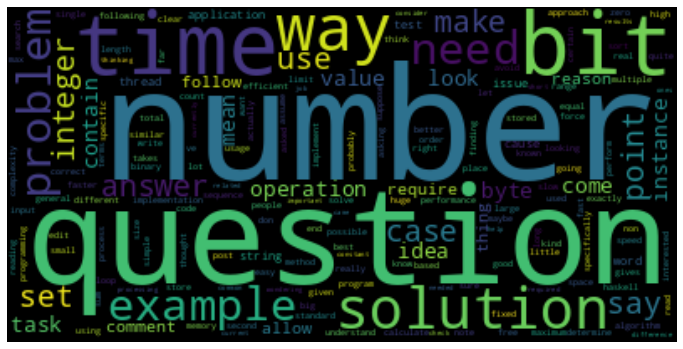

Topic 1:
project new element elements remove build add operator ve solution


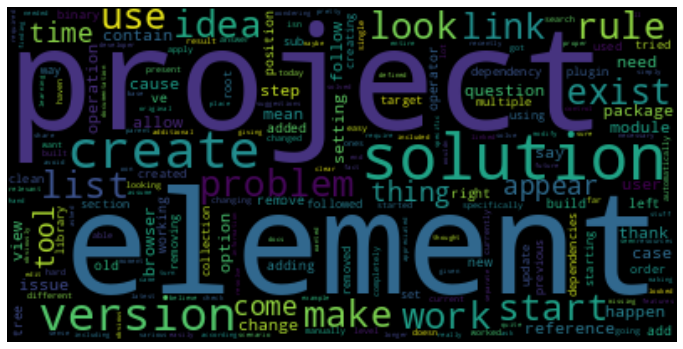

Topic 2:
com https source http google service xml github org play


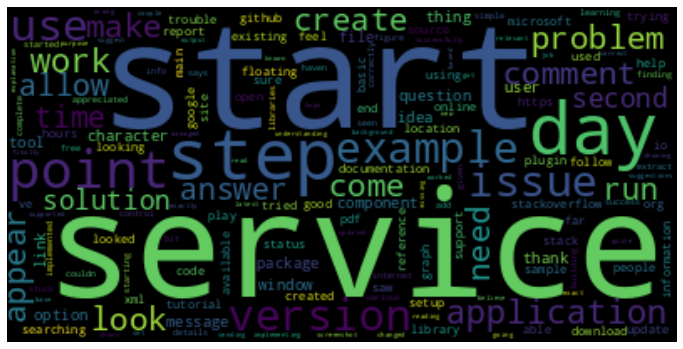

Topic 3:
app android user ios application react index device date using


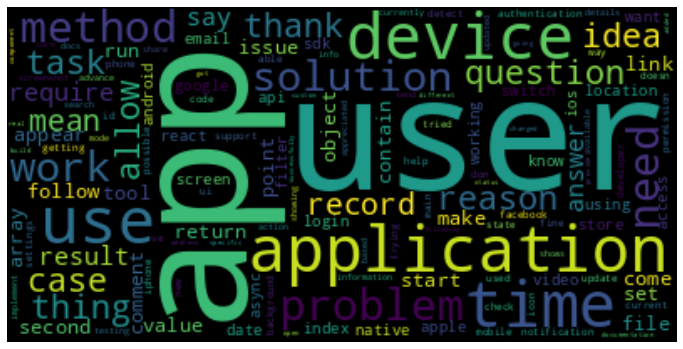

Topic 4:
string way like convert use using strings want best format


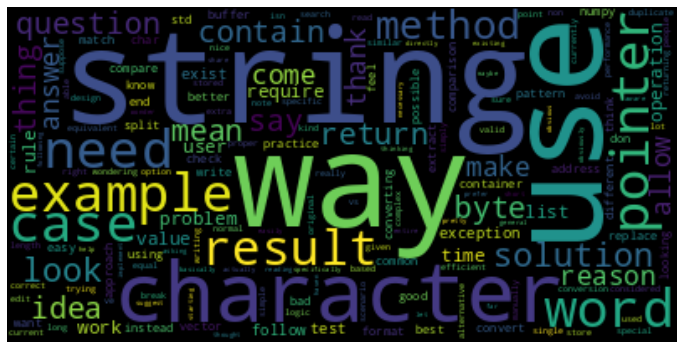

Topic 5:
server json api request default git web client response using


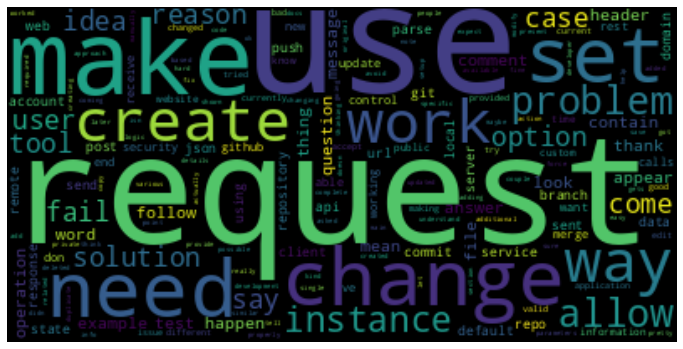

Topic 6:
js javascript value form input key node field jquery item


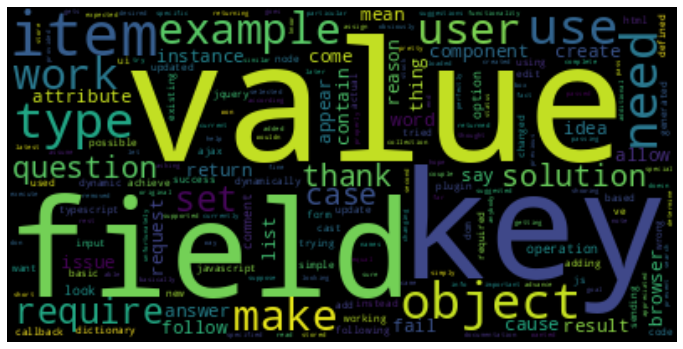

Topic 7:
php functions thread language use generate random course feature like


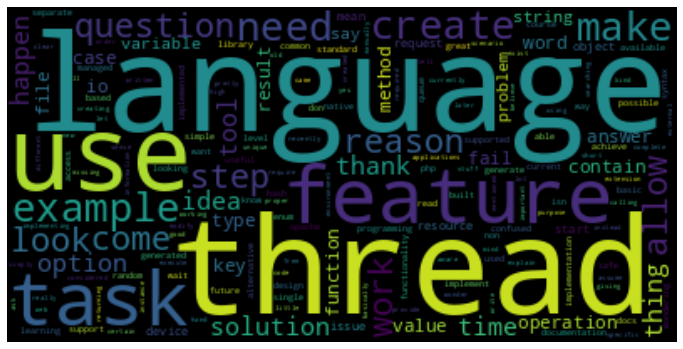

Topic 8:
code python like use work using just know don doesn


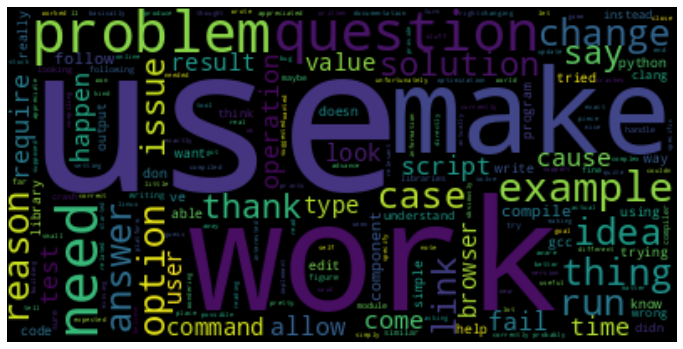

Topic 9:
java data exception map structure arrays gradle arguments spring firebase


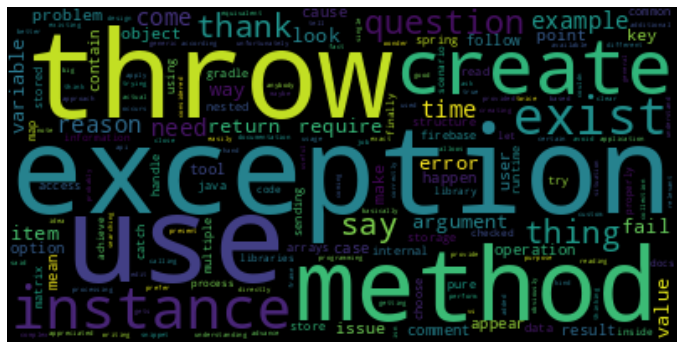

Topic 10:
list data table database query sql column like using want


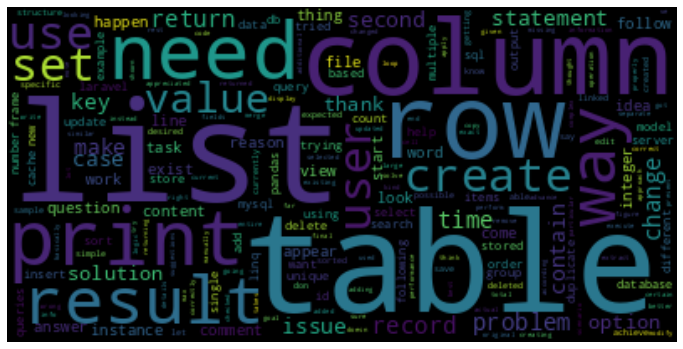

Topic 11:
error code following studio getting message visual errors compile tried


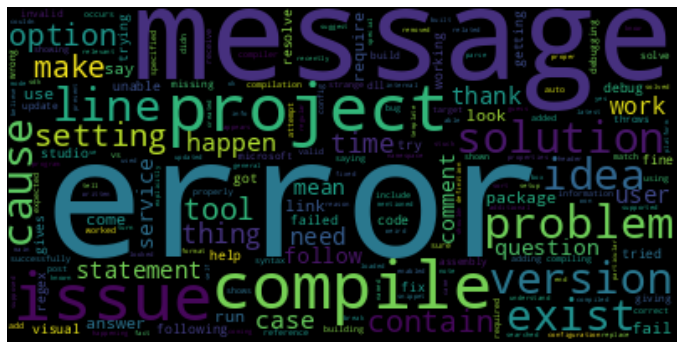

Topic 12:
class type object method like objects use methods classes reference


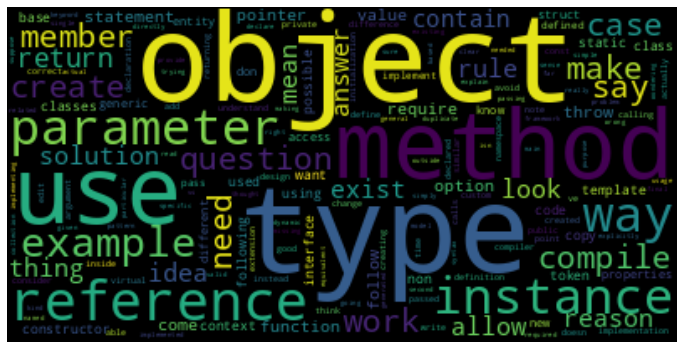

Topic 13:
function array value null pointer standard type undefined return int


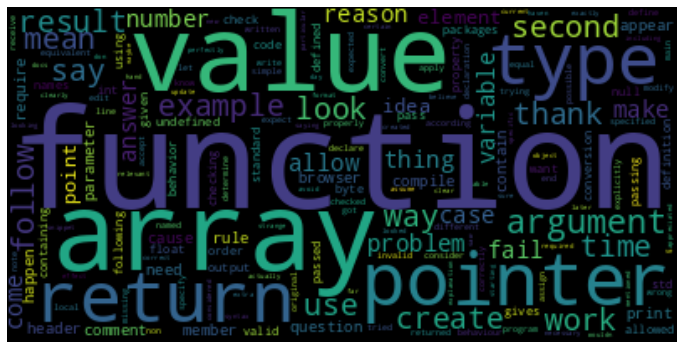

Topic 14:
code test net time run output core using does difference


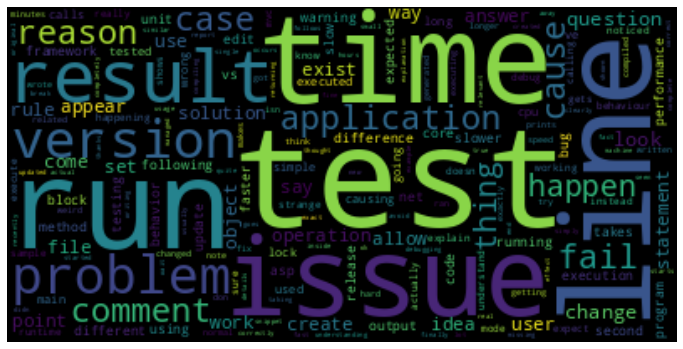

Topic 15:
button chrome browser component click event console window log website


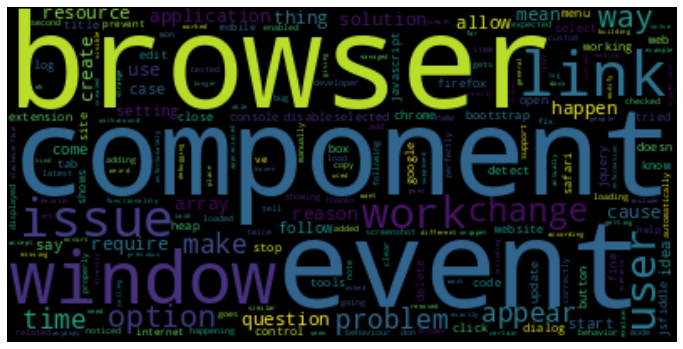

Topic 16:
file files line page script using swift load folder read


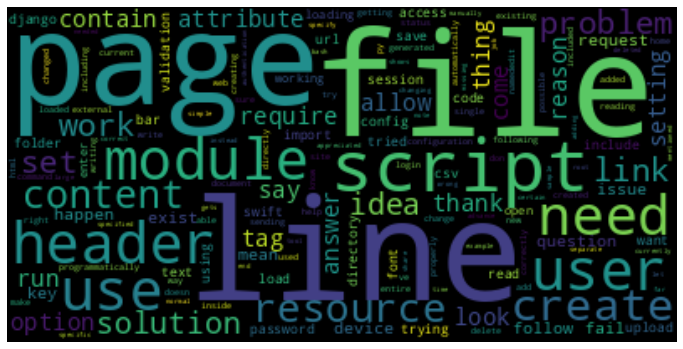

Topic 17:
image view html text angular like using want css page


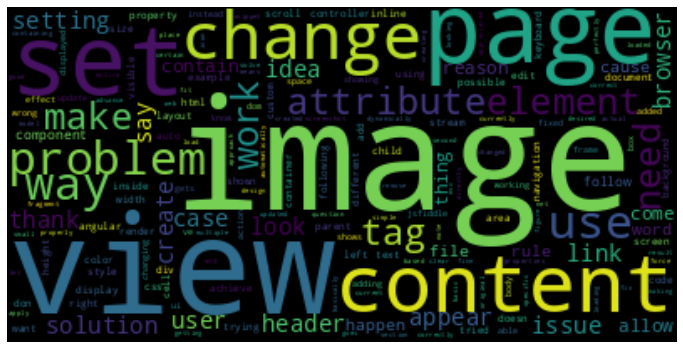

Topic 18:
run windows running version command 10 using application package installed


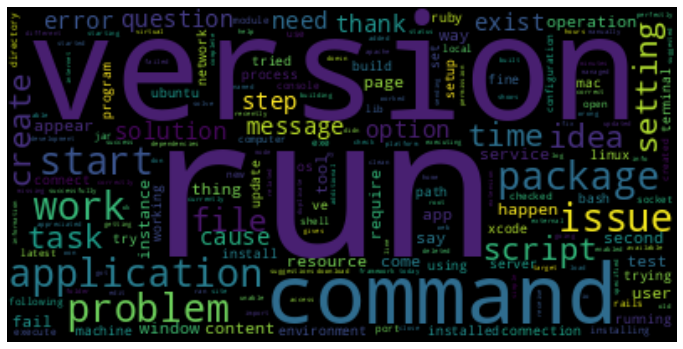

Topic 19:
variable does called code value loop returns variables return compiler


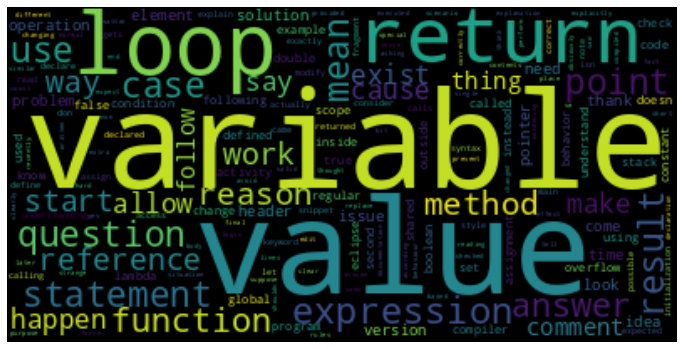

In [46]:
for topic_idx, topic in enumerate(lda.components_):
    #affichage des 500 premiers motes par topics
    plt.subplots(figsize=(12,8))
    print("Topic {}:".format(topic_idx))
    print(" ".join([tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]))
    text = " ".join([tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-500 - 1:-1]])
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# LDA sur text cleaned

In [15]:
documents_clean = [' '.join(map(str, l)) for l in data.text]

In [16]:
documents_clean[0]

'item array array number method element way element array equivalent something core javascript framework'

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 20

tf_vectorizer_clean = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_clean = tf_vectorizer_clean.fit_transform(documents_clean)

In [18]:
# Créer le modèle LDA
lda_clean = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda_clean.fit(tf_clean)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [19]:
no_top_words = 10
display_topics(lda_clean, tf_vectorizer_clean.get_feature_names(), no_top_words)

Topic 0:
app io google xcode device swift user version issue branch
Topic 1:
pointer point operator node map expression syntax code video day
Topic 2:
data line key json structure code firebase frame format way
Topic 3:
array number element value size integer way algorithm time example
Topic 4:
image page javascript code link browser html button website token
Topic 5:
error version code message module template gcc project compiler issue
Topic 6:
code java program loop exception statement language output block way
Topic 7:
function string value variable character return way date example code
Topic 8:
object type property reference parameter method interface copy assignment print
Topic 9:
file command project script package path warning console folder directory
Topic 10:
method python list user way event code dictionary time example
Topic 11:
memory thread core process task project standard application dependency time
Topic 12:
class constructor instance member word way context pattern b

In [20]:
data.dtypes

tags         object
full_text    object
text         object
score         int64
dtype: object

Au vu des resultats il est difficile de nommer un topic en particulier, les mots sont trop varies , on par exemple que quelques topics semblent assez coherent comme les sujets relatif au base de donnees ou reseau

<a name='op'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Nombre de topics optimal
        </h1>
    </div>
</div>




- Afin de sélectionner le meilleur nombre de topics pour nos données, nous allons itérer sur une fourchette de nombre de topics et tester le score de cohérence pour chaque modèle :

In [21]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(data.text)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in data.text]  

In [23]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore.LdaMulticore(
                                                        corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=k,
                                                        random_state=8,
                                                        per_word_topics=True,
                                                        workers=4)
    coherence_model_lda = CoherenceModel(
                                            model=lda_model,
                                            texts=data["text"],
                                            dictionary=id2word,
                                            coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


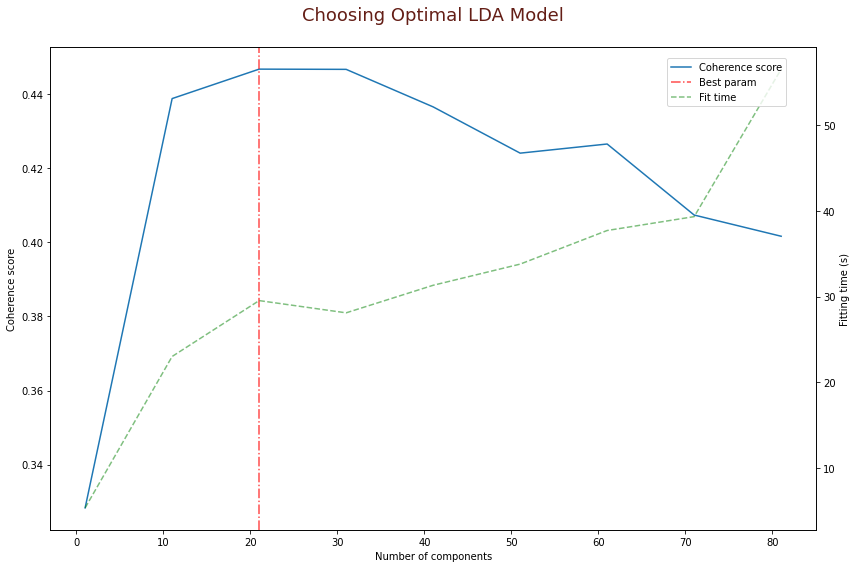

In [24]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [25]:
best_nb_topics

21

Creation du bag of word

In [29]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:2])

[[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency. Exemple : (6,3) ci-dessus indique que word_id 6 apparaît 3 fois dans le document et ainsi de suite.
Les mots les plus fréquents ont ici aussi été filtrés grâce à la fonction filter_extremes réglée à 60% comme pour le Tfidf.

Pour voir quel mot correspond à un identifiant donné, il faut transmettre l'identifiant comme clé du dictionnaire.

In [32]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('array', 3),
  ('core', 1),
  ('element', 2),
  ('equivalent', 1),
  ('framework', 1),
  ('item', 1),
  ('javascript', 1),
  ('method', 1),
  ('number', 1),
  ('something', 1),
  ('way', 1)]]

Nous allons à présent entrainer le modèle LDA sur Full_doc puis afficher les métriques : 
- **Perplexity** : $(\exp(-1 \times \text{log-likelihood})$ *(Log likelihood : Densité de vraisemblance)*
- **Coherence Score** : Les mesures de cohérence de topics évaluent un seul topic en mesurant le degré de similitude sémantique entre les mots à score élevé dans ce dernier.       Pour en savoir plus sur ce Pipeline 

In [33]:
# Build LDA model
import gensim
full_lda_model = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=20,
    random_state=8,
    per_word_topics=True,
    workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.03284251881742

Coherence Score:  0.4388432848486331


In [34]:
vis_data = gensimvis.prepare(full_lda_model, corpus, id2word)
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))
display(HTML(pyLDAvis.prepared_data_to_html(vis_data)))

/home/ismail/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


LDA n'est pas adaptée. En effet, le meilleur nombre de topics se situerait à 20, mais l'algorithme ne parvient pas a établir de groupes bien distincts. Un certain nombre de topics sont très regroupés et donc représentés par les mêmes termes.




<a name='nmf'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          NMF
        </h1>
    </div>
</div>

Le modèle NMF ne peut malheureusement pas être scoré. Nous allons donc nous baser sur les résultats de la LDA pour déterminer un nombre correct de composants. Ici, nous prendrons 20 topics pour avoir un bon compromis "temps d'entrainement" / précision et utiliserons les matrices Tfidf créées lors du preprocessing.

In [46]:
# Define X and y
X = data["text"]
y = data["tags"]

# Initialize the "CountVectorizer" TFIDF for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
#                              tokenizer=True,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

X_tfidf = vectorizer.fit_transform(X)
tfidf_feature_names = vectorizer.get_feature_names()


print("Shape of X for text: {}".format(X_tfidf.shape))


Shape of X for text: (93701, 569)


In [44]:
no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(X_tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
code line compiler output loop time question result program gcc
Topic 1:
error message project command server version module problem package issue
Topic 2:
class constructor instance member base interface name variable field property
Topic 3:
function argument pointer parameter call way variable example return javascript
Topic 4:
file directory line folder git project command path php header
Topic 5:
string character regex char way json length format text word
Topic 6:
array element pointer size index memory numpy byte way length
Topic 7:
table data query column row sql database server mysql record
Topic 8:
python script module command package window way version numpy dictionary
Topic 9:
list element item way order index dictionary example loop collection
Topic 10:
object property json reference javascript constructor pointer way key instance
Topic 11:
type pointer compiler parameter template argument operator int return data
Topic 12:
app android device application project st

/home/ismail/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


les topics générés restent très généraux et ne permettent pas une catégorisation cohérente pour notre problème d'auto-tagging. Nous allons donc tester des modèles supervisés.